In [100]:
import pickle
import pandas as pd
import polars as pl
import numpy as np
import dtwsom
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [101]:
kdprov='32'
df_variabce=pd.read_pickle(f'/data/ksa/04_Data_Preprocessing/{kdprov}/02_variance_filtering/variance_filtering.pkl')

In [102]:
df_training_vh=pd.read_pickle(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_imputation_{kdprov}_VH.pkl')
df_training_vv=pd.read_pickle(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_imputation_{kdprov}_VV.pkl')
df_training_vh=pl.from_pandas(df_training_vh)
df_training_vv=pl.from_pandas(df_training_vv)

In [79]:
df_training_vv_var=df_training_vv.filter(
    (pl.col("idsubsegment").is_in(df_variabce.idsubsegment))
)
df_training_vh_var=df_training_vh.filter(
    (pl.col("idsubsegment").is_in(df_variabce.idsubsegment))
)
df_inner = df_training_vv_var.join(df_training_vh_var, 
                                   on=['idpoint','idsubsegment','idsegment','nth',
                                       'periode','observation','class','MGRS'], how="inner")

In [103]:
df_select=df_inner.select(['idpoint','nth','MGRS','periode','idsubsegment',
                           'VV_10', 'VV_9', 'VV_8', 'VV_7', 'VV_6', 'VV_5', 'VV_4', 'VV_3', 'VV_2', 'VV_1',
                           'VV_0',  'VH_10', 'VH_9', 'VH_8', 'VH_7', 'VH_6', 'VH_5','VH_4', 'VH_3', 'VH_2', 
                           'VH_1', 'VH_0'])

In [104]:
bridging_date=pd.read_excel("/data/ksa/03_Sampling/bridging.xlsx", dtype='object', sheet_name="periode_to_date")
df_variabce['periode_start']=df_variabce['periode'].apply(lambda y: y.split('_')[0][4:])
df_variabce['periode_end']=df_variabce['periode'].apply(lambda y: y.split('_')[1][4:])
df_variabce['tahun']=df_variabce['periode'].apply(lambda y: y[:4])

In [105]:
df_variabce=df_variabce.merge(bridging_date.query('is_kabisat==0')[['periode_start','periode_end','id_per_image']])
df_variabce['periode_y']=df_variabce.apply(lambda y: str(y.tahun)+'_'+str(y.id_per_image).zfill(2),axis=1)
df_variabce['periode_x']=df_variabce['periode']
df_variabce['periode']=df_variabce['periode_y']
df_10_variance=df_variabce.query('less_q10==True')
data_for_dtw=df_select.join(pl.from_dataframe(df_10_variance[['periode','idsubsegment','obs']]),
               on=['idsubsegment','periode'],how='inner').to_pandas()
data_for_dtw_drop=data_for_dtw.drop(columns=['MGRS'],axis=1)

In [106]:
with open(f'//data/ksa/04_Data_Preprocessing/training-test/{kdprov}/som_training_yy.pkl','rb') as file:
    som=pickle.load(file)
    weights = som.get_weights()

In [107]:
def som_winner(data,som):
    dummy=np.zeros((2,11))
    dummy[0,:]=[ data[f'VV_{i}'] for i in range(0,11) ]
    dummy[1,:]=[ data[f'VV_{i}'] for i in range(0,11) ]
    return som.winner(dummy)

In [108]:
data_for_dtw_pl=pl.from_pandas(data_for_dtw)
rows = data_for_dtw_pl.to_dicts()

In [109]:
# Define the function to process each row
def process_row(row):
    return som_winner(row, som)
# Initialize a list to store the results
som_rep_list = []
# Use ProcessPoolExecutor to run the computation in parallel
with ProcessPoolExecutor(max_workers=30) as executor:
    # Submit all tasks to the executor
    futures = [executor.submit(process_row, row) for row in rows]
    # Use tqdm to display the progress bar
    for future in tqdm(as_completed(futures), total=len(futures)):
        # Collect the result from each future
        som_rep_list.append(future.result())
# Add the results back to the Polars DataFrame
data_for_dtw_pl = data_for_dtw_pl.with_columns(pl.Series("som_rep", som_rep_list))

100%|██████████| 1074500/1074500 [57:36<00:00, 310.84it/s] 


In [110]:
df_data=data_for_dtw_pl.to_pandas()
df_data['som_rep2']=df_data.som_rep.apply(lambda y:str(f'R{y[0]}C{y[1]}'))
with open(f'//data/ksa/04_Data_Preprocessing/training-test/{kdprov}/som_winner.pkl','wb') as file:
    pickle.dump(df_data,file)
pivoting=pd.pivot_table(df_data, 
               columns='obs',index='som_rep2',values='idpoint',aggfunc='count',fill_value=0)

In [113]:
print(pivoting.values)

[[   36    10    20    26    10    36   122]
 [    3     1     2     2     0     1     1]
 [   57     3     0    35   141     0     3]
 [   48     1     0     3    58     0     1]
 [10783  9905 17642  7975  6003   987  1414]
 [42114 30536 39971 42136 22686  9087  7849]
 [ 3335  2414  3230  4145  1696  4464  8818]
 [  102    59    83    87    40   108   287]
 [    0     0     0     0     1     0     1]
 [ 6997  4175  3272  5482  4655  1689  1233]
 [ 1248   113    85   883  2561    57    79]
 [20500 22401 25499 23118  8110 15269 10524]
 [ 5625  4300  5858  7456  2649  9579 12828]
 [  232   152   209   264    91   261   704]
 [    1     1     0     0     0     1     4]
 [    0     0     0     0     1     0     2]
 [  138   102   128   160    68   187   411]
 [ 1122   859  1152  1423   553  1456  3297]
 [   11    17     9    14     9    27    72]
 [  146   100   164   174    82   211   443]
 [   94    63   101   114    39   112   286]
 [    1     1     2     2     1     4     6]
 [    6   

In [114]:
row_totals = pivoting.sum(axis=1)

In [116]:
row_totals.values

array([   260,     10,    239,    111,  54709, 194379,  28102,    766,
            2,  27503,   5026, 125421,  48295,   1913,      7,      3,
         1194,   9862,    159,   1320,    809,     17,     67,    610,
           25,      2,     70,     19,      5,      8,      1,      3,
           49,      4,      7,    788,      6,      1,     36,     11,
           11,     12,    371,     35,    108,    308,      2,    316,
          345,      1,    318,   2550,    205,     89,   1090,    425,
            4,  10418,      7,   4750,    249,      1,      5,    246,
           13,    124,    584,  49947,     34,  28720,      5,    443,
            8,   7315,     44,      2,    250,      4,     24,     20,
       150047,   2889,      5,      1,    170,    566,   9812,  11665,
       286341,   1769,     13])

In [118]:
row_totals = pivoting.sum(axis=1)

# Calculate percentages
percentage_df = pivoting.div(row_totals, axis=0) * 100

# Reset the index if you want 'Category' as a column again
#percentage_df.reset_index(inplace=True)
print(percentage_df.values)

[[ 13.84615385   3.84615385   7.69230769  10.           3.84615385
   13.84615385  46.92307692]
 [ 30.          10.          20.          20.           0.
   10.          10.        ]
 [ 23.84937238   1.25523013   0.          14.64435146  58.9958159
    0.           1.25523013]
 [ 43.24324324   0.9009009    0.           2.7027027   52.25225225
    0.           0.9009009 ]
 [ 19.70973697  18.10488219  32.24697947  14.57712625  10.97260049
    1.80409073   2.58458389]
 [ 21.6659207   15.70951595  20.56343535  21.6772388   11.67101384
    4.67488772   4.03798764]
 [ 11.86748274   8.59013593  11.49384385  14.74983987   6.03515764
   15.88499039  31.37854957]
 [ 13.31592689   7.70234987  10.83550914  11.35770235   5.22193211
   14.09921671  37.46736292]
 [  0.           0.           0.           0.          50.
    0.          50.        ]
 [ 25.440861    15.18016216  11.89688398  19.93237101  16.92542632
    6.14114824   4.48314729]
 [ 24.83087943   2.24830879   1.69120573  17.56864306  50

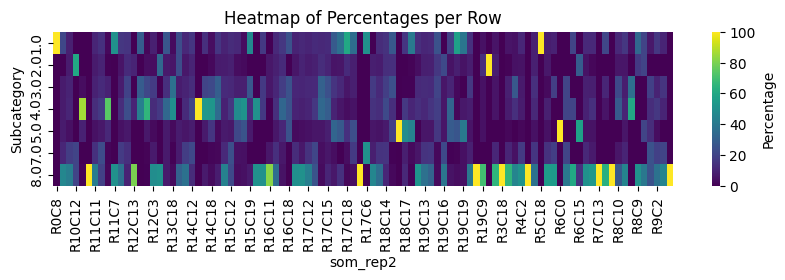

In [67]:
plt.figure(figsize=(10, 2))
sns.heatmap(percentage_df.set_index('som_rep2').T, annot=False, cmap='viridis', cbar_kws={'label': 'Percentage'})
plt.title('Heatmap of Percentages per Row')
plt.xlabel('som_rep2')
plt.ylabel('Subcategory')
plt.show()

In [70]:
target=df_data.obs.values

In [ ]:
np_dtw=np.zeros((df_data.shape[0],2,31))
np_dtw[:,0,:]=gab_median_frac.iloc[:,:][[f'VV_{i}' for i in range(0,31)]].to_numpy()
np_dtw[:,1,:]=gab_median_frac.iloc[:,:][[f'VH_{i}' for i in range(0,31)]].to_numpy()

In [72]:
som.labels_map(

Signature: som.labels_map(data, labels)
Docstring:
Returns a dictionary wm where wm[(i,j)] is a dictionary
that contains the number of samples from a given label
that have been mapped in position i,j.

Parameters
----------
data : np.array or list
    Data matrix.

label : np.array or list
    Labels for each sample in data.
File:      ~/.local/lib/python3.10/site-packages/dtwsom/dtwsom.py
Type:      method